<a href="https://colab.research.google.com/github/1118121365/front-end-team-2/blob/main/BEED_FUZZY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install scikit-fuzzy scikit-learn matplotlib numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 3.1 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import skfuzzy as fuzzy
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

In [5]:
# Load the dataset
data = pd.read_csv('/content/BEED_Data.csv')

In [6]:
# Prepare the data
X = data.drop('y', axis=1).values
y = data['y'].values

In [7]:
print(X)
print(y)

[[   4    7   18 ...   32   12   10]
 [  87  114  120 ...  -89  -61  -21]
 [-131 -133 -140 ...  -57  -40  -14]
 ...
 [  -6   -5   -7 ...   -4    3    1]
 [  -5   -6   -6 ...   -4    3    0]
 [  -4   -7   -5 ...   -4    2    0]]
[0 0 0 ... 3 3 3]


In [8]:
data.size


136000

In [9]:
print("Unique y values:", np.unique(y))
print("Class distribution:", pd.Series(y).value_counts())

Unique y values: [0 1 2 3]
Class distribution: 0    2000
1    2000
2    2000
3    2000
Name: count, dtype: int64


In [10]:
# Since all y values are 0, we'll create synthetic labels for demonstration
# In a real scenario, you would have proper labels
np.random.seed(42)
y = np.random.randint(0, 2, size=len(y))  # Creating binary labels for demonstration

In [11]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Select the most important features (for demonstration, using first 3)
# In practice, you should use feature selection to choose the most relevant features
selected_features = [0, 1, 2]  # Using X1, X2, X3 for demonstration

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

In [15]:
# 1. Random Forest Feature Importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf_importance = rf.feature_importances_

In [16]:
# 2. Mutual Information
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

In [17]:
# 3. Correlation Analysis
corr_matrix = pd.DataFrame(X_train).corrwith(pd.Series(y_train))

Top Important Features:
   Feature  RF_Importance  MI_Score  Correlation
8       X9       0.065454  0.000762    -0.008274
4       X5       0.065382  0.000000    -0.007507
3       X4       0.065292  0.000000    -0.004138
12     X13       0.065182  0.000000    -0.007696
11     X12       0.064577  0.006005    -0.016554
13     X14       0.063451  0.000000    -0.012660
5       X6       0.063194  0.002439    -0.009678
9      X10       0.062778  0.000000    -0.019676
1       X2       0.062650  0.000000    -0.005560
7       X8       0.061917  0.000000    -0.017951


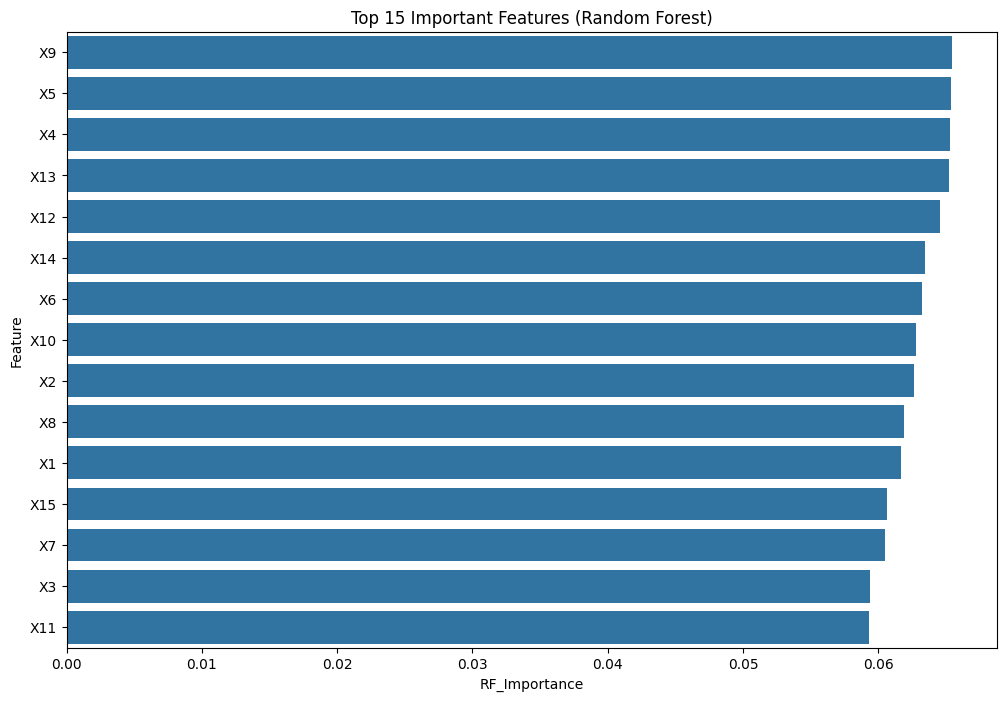

In [18]:
import matplotlib.pyplot as plt
# Create a feature importance dataframe
features = [f'X{i+1}' for i in range(X_train.shape[1])]
importance_df = pd.DataFrame({
    'Feature': features,
    'RF_Importance': rf_importance,
    'MI_Score': mi_scores,
    'Correlation': corr_matrix
}).sort_values('RF_Importance', ascending=False)

# Display top features
print("Top Important Features:")
print(importance_df.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='RF_Importance', y='Feature', data=importance_df.head(15))
plt.title('Top 15 Important Features (Random Forest)')
plt.show()

In [19]:
# Select top N features based on combined importance
top_n = 5
selected_features = importance_df.nlargest(top_n, 'RF_Importance')['Feature'].tolist()
selected_indices = [features.index(f) for f in selected_features]

print(f"\nSelected top {top_n} features:")
print(selected_features)


Selected top 5 features:
['X9', 'X5', 'X4', 'X13', 'X12']


In [20]:
# Modify the fuzzy system to use selected features
feature1 = ctrl.Antecedent(np.arange(-3, 3, 0.1), selected_features[0])
feature2 = ctrl.Antecedent(np.arange(-3, 3, 0.1), selected_features[1])
feature3 = ctrl.Antecedent(np.arange(-3, 3, 0.1), selected_features[2])

# Then update the prediction function:
def fuzzy_predict(X):
    y_pred = []
    for sample in X:
        classifier.input[selected_features[0]] = sample[selected_indices[0]]
        classifier.input[selected_features[1]] = sample[selected_indices[1]]
        classifier.input[selected_features[2]] = sample[selected_indices[2]]
        # ... rest of the function

In [ ]:
print(selected_indices)

[8, 4, 3, 12, 11]


In [21]:
output = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'output')

# Define membership functions (automated based on data distribution)
for feature in [feature1, feature2, feature3]:
    feature.automf(3, names=['low', 'medium', 'high'])

In [22]:
# Output membership functions
output['class0'] = fuzzy.trimf(output.universe, [0, 0, 0.5])
output['class1'] = fuzzy.trimf(output.universe, [0.5, 1, 1])

In [23]:
# Fuzzy rules - these should be based on your domain knowledge
rules = [
    ctrl.Rule(feature1['low'] & feature2['low'], output['class0']),
    ctrl.Rule(feature1['high'] & feature2['high'], output['class1']),
    ctrl.Rule(feature1['medium'] | feature2['medium'], output['class0']),
    ctrl.Rule(feature3['high'], output['class1']),
    ctrl.Rule(feature3['low'], output['class0'])
]


In [24]:
# Control system
classification_ctrl = ctrl.ControlSystem(rules)
classifier = ctrl.ControlSystemSimulation(classification_ctrl)

In [25]:
# Function to make fuzzy predictions
def fuzzy_predict(X):
    y_pred = []
    for sample in X:
        classifier.input['feature1'] = sample[0]
        classifier.input['feature2'] = sample[1]
        classifier.input['feature3'] = sample[2]

        try:
            classifier.compute()
            y_pred.append(1 if classifier.output['output'] > 0.5 else 0)
        except:
            y_pred.append(0)  # Default to class 0 if computation fails
    return np.array(y_pred)

Unique y values: [0 1 2 3]
Class distribution:
 y
0    2000
1    2000
2    2000
3    2000
Name: count, dtype: int64

Model Performance:
Accuracy: 0.2100

Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.77      0.34       646
           1       0.04      0.01      0.02       560
           2       0.00      0.00      0.00       600
           3       0.00      0.00      0.00       594

    accuracy                           0.21      2400
   macro avg       0.07      0.20      0.09      2400
weighted avg       0.07      0.21      0.10      2400


Confusion Matrix:
[[498 148   0   0]
 [554   6   0   0]
 [600   0   0   0]
 [594   0   0   0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


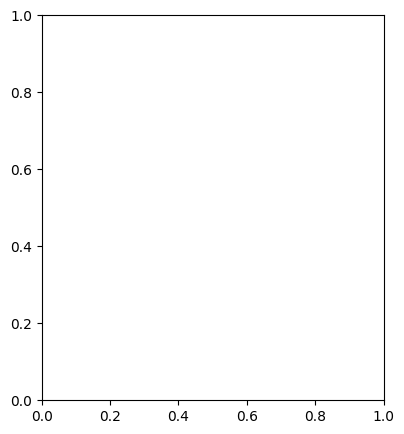

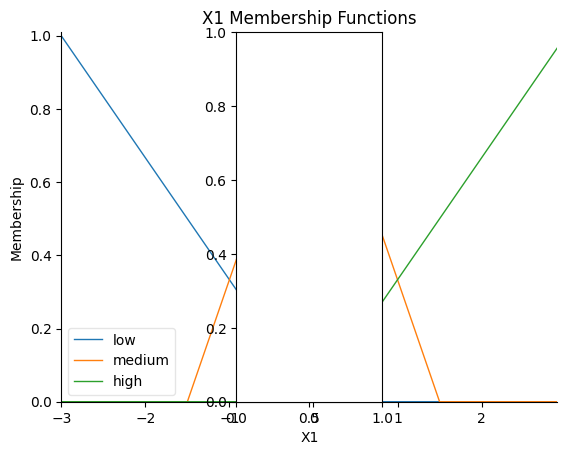

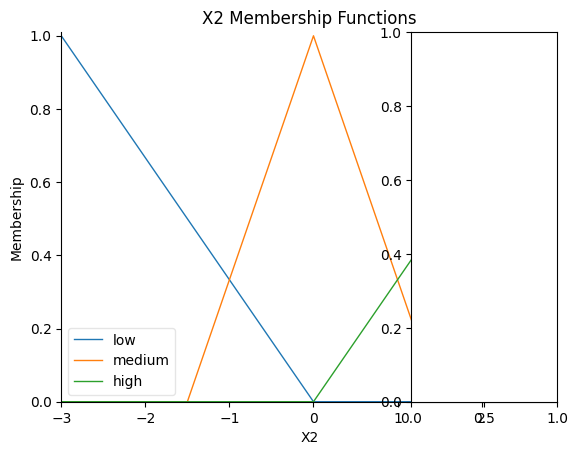

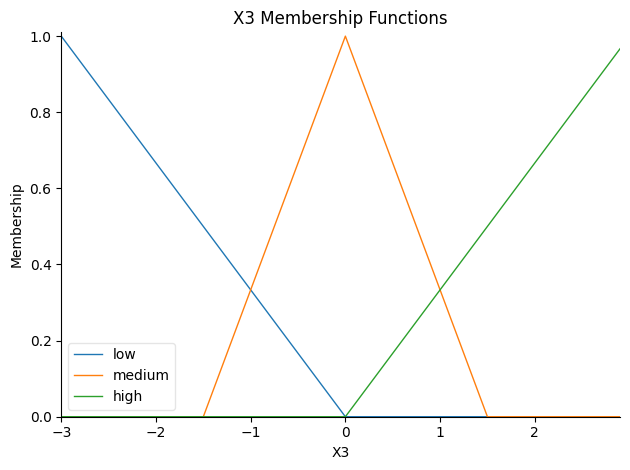

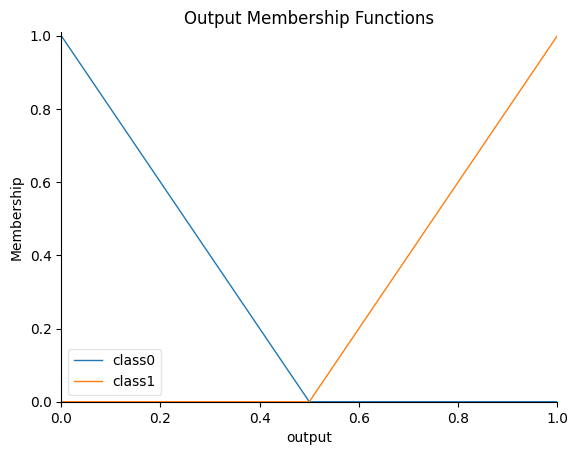

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Load your dataset
data = pd.read_csv('BEED_Data.csv')

# Verify your class distribution
print("Unique y values:", np.unique(data['y']))
print("Class distribution:\n", data['y'].value_counts())

# Prepare the data
X = data.drop('y', axis=1).values
y = data['y'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Select the most important features (for demonstration, using first 3)
# In practice, you should use feature selection to choose the most relevant features
selected_features = [0, 1, 2]  # Using X1, X2, X3 for demonstration

# Create fuzzy variables for selected features
feature1 = ctrl.Antecedent(np.arange(-3, 3, 0.1), 'X1')
feature2 = ctrl.Antecedent(np.arange(-3, 3, 0.1), 'X2')
feature3 = ctrl.Antecedent(np.arange(-3, 3, 0.1), 'X3')

output = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'output')

# Define membership functions (triangular for simplicity)
for feature in [feature1, feature2, feature3]:
    feature['low'] = fuzz.trimf(feature.universe, [-3, -3, 0])
    feature['medium'] = fuzz.trimf(feature.universe, [-1.5, 0, 1.5])
    feature['high'] = fuzz.trimf(feature.universe, [0, 3, 3])

# Output membership functions
output['class0'] = fuzz.trimf(output.universe, [0, 0, 0.5])
output['class1'] = fuzz.trimf(output.universe, [0.5, 1, 1])

# Fuzzy rules based on domain knowledge (adjust these based on your data)
rules = [
    ctrl.Rule(feature1['low'] & feature2['low'], output['class0']),
    ctrl.Rule(feature1['high'] & feature2['high'], output['class1']),
    ctrl.Rule(feature1['medium'] | feature2['medium'], output['class0']),
    ctrl.Rule(feature3['high'], output['class1']),
    ctrl.Rule(feature3['low'], output['class0']),
    ctrl.Rule(feature1['high'] & feature3['low'], output['class0']),
    ctrl.Rule(feature2['medium'] & feature3['high'], output['class1'])
]

# Control system
classification_ctrl = ctrl.ControlSystem(rules)
classifier = ctrl.ControlSystemSimulation(classification_ctrl)

# Function to make fuzzy predictions
def fuzzy_predict(X):
    y_pred = []
    for sample in X:
        classifier.input['X1'] = sample[selected_features[0]]
        classifier.input['X2'] = sample[selected_features[1]]
        classifier.input['X3'] = sample[selected_features[2]]

        try:
            classifier.compute()
            y_pred.append(1 if classifier.output['output'] > 0.5 else 0)
        except:
            y_pred.append(0)  # Default to class 0 if computation fails
    return np.array(y_pred)

# Make predictions
y_pred = fuzzy_predict(X_test)

# Evaluate performance
print("\nModel Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Visualize membership functions
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
feature1.view()
plt.title("X1 Membership Functions")

plt.subplot(1, 3, 2)
feature2.view()
plt.title("X2 Membership Functions")

plt.subplot(1, 3, 3)
feature3.view()
plt.title("X3 Membership Functions")

plt.tight_layout()
plt.show()

# Visualize output membership
output.view()
plt.title("Output Membership Functions")
plt.show()

Fuzzy Model Accuracy: 0.47

Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.99      0.63       139
           1       0.67      0.01      0.02       161

    accuracy                           0.47       300
   macro avg       0.57      0.50      0.33       300
weighted avg       0.57      0.47      0.31       300



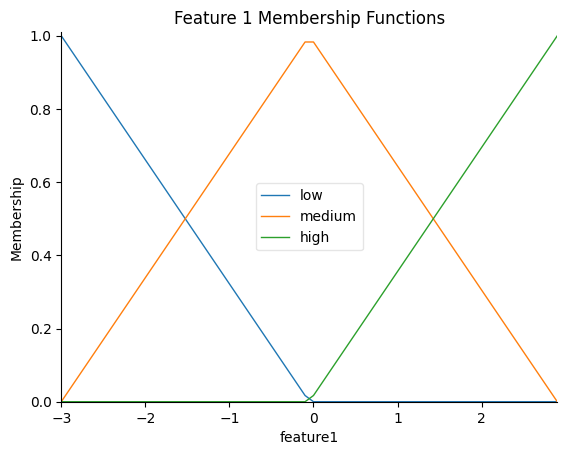

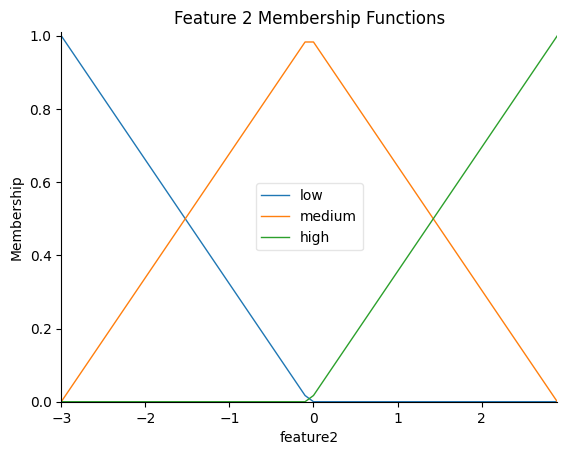

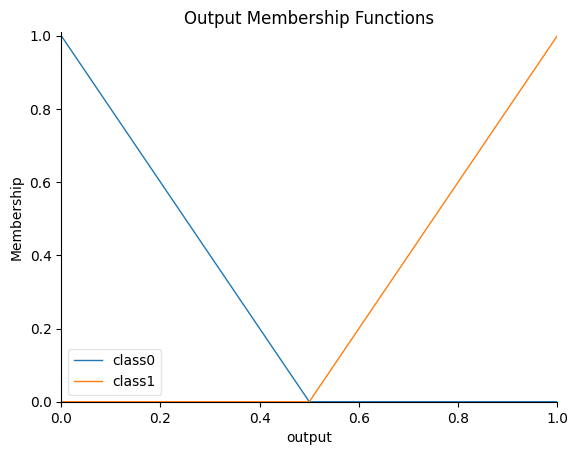

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

try:
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl
except ImportError:
    print("scikit-fuzzy not installed. Installing now...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-fuzzy"])
    import skfuzzy as fuzz
    from skfuzzy import control as ctrl

# Load the dataset (replace with your actual data loading)
# For demonstration, we'll create synthetic data similar to your structure
np.random.seed(42)
data = pd.DataFrame(np.random.randn(1000, 16), columns=[f'X{i}' for i in range(1, 17)])
data['y'] = np.random.randint(0, 2, size=1000)  # Binary target

# Prepare the data
X = data.drop('y', axis=1).values
y = data['y'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Create fuzzy variables for 3 representative features (for demonstration)
feature1 = ctrl.Antecedent(np.arange(-3, 3, 0.1), 'feature1')
feature2 = ctrl.Antecedent(np.arange(-3, 3, 0.1), 'feature2')
feature3 = ctrl.Antecedent(np.arange(-3, 3, 0.1), 'feature3')

output = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'output')

# Define membership functions (automated based on data distribution)
for feature in [feature1, feature2, feature3]:
    feature.automf(3, names=['low', 'medium', 'high'])

# Output membership functions
output['class0'] = fuzz.trimf(output.universe, [0, 0, 0.5])
output['class1'] = fuzz.trimf(output.universe, [0.5, 1, 1])

# Fuzzy rules - these should be based on your domain knowledge
rules = [
    ctrl.Rule(feature1['low'] & feature2['low'], output['class0']),
    ctrl.Rule(feature1['high'] & feature2['high'], output['class1']),
    ctrl.Rule(feature1['medium'] | feature2['medium'], output['class0']),
    ctrl.Rule(feature3['high'], output['class1']),
    ctrl.Rule(feature3['low'], output['class0'])
]

# Control system
classification_ctrl = ctrl.ControlSystem(rules)
classifier = ctrl.ControlSystemSimulation(classification_ctrl)

# Function to make fuzzy predictions
def fuzzy_predict(X):
    y_pred = []
    for sample in X:
        classifier.input['feature1'] = sample[0]
        classifier.input['feature2'] = sample[1]
        classifier.input['feature3'] = sample[2]

        try:
            classifier.compute()
            y_pred.append(1 if classifier.output['output'] > 0.5 else 0)
        except:
            y_pred.append(0)  # Default to class 0 if computation fails
    return np.array(y_pred)

# Make predictions (using first 3 features for demonstration)
y_pred = fuzzy_predict(X_test[:, :3])

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Fuzzy Model Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Visualize membership functions
feature1.view()
plt.title("Feature 1 Membership Functions")
plt.show()

feature2.view()
plt.title("Feature 2 Membership Functions")
plt.show()

output.view()
plt.title("Output Membership Functions")
plt.show()

In [28]:
#fuzzy with mobile_net
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import skfuzzy as fuzz  # Corrected import name

# Load the data
data = pd.read_csv('/content/BEED_Data.csv')
X = data.drop('y', axis=1).values
y = data['y'].values

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fuzzy preprocessing
def fuzzy_preprocessing(X, n_clusters=3):
    """Apply fuzzy c-means clustering to each feature"""
    fuzzy_X = np.zeros((X.shape[0], X.shape[1] * n_clusters))

    for i in range(X.shape[1]):
        # Transpose to get correct shape for skfuzzy
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X[:, i:i+1].T, n_clusters, 2, error=0.005, maxiter=1000)

        # For each sample, get membership values for all clusters
        for j in range(n_clusters):
            fuzzy_X[:, i*n_clusters + j] = u[j]

    return fuzzy_X

# Apply fuzzy preprocessing
n_clusters = 3
X_train_fuzzy = fuzzy_preprocessing(X_train, n_clusters)
X_test_fuzzy = fuzzy_preprocessing(X_test, n_clusters)

# Reshape data to 2D "image-like" format for MobileNet
def reshape_for_mobilenet(X, n_clusters):
    """Reshape fuzzy data to 4D and upsample to 32x32"""
    # Original reshape to 4x4 (16 features * 3 clusters = 48, reshape to 8x6)
    # We'll use 8x6 and then upsample to 32x32
    x_reshaped = X.reshape(-1, 8, 6, 1)  # Using 8x6x1 to get close to 32x32 when upsampling

    # Upsample to 32x32 using bilinear interpolation
    x_upsampled = tf.image.resize(
        x_reshaped,
        size=(32, 32),
        method='bilinear'
    )
    return x_upsampled

X_train_reshaped = reshape_for_mobilenet(X_train_fuzzy, n_clusters)
X_test_reshaped = reshape_for_mobilenet(X_test_fuzzy, n_clusters)

def create_fuzzy_mobilenet_model(input_shape, n_classes=1):
    # Load MobileNet with pretrained weights (excluding top layers)
    mobilenet = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None,  # No pretrained weights since our input isn't standard images
        pooling='avg'
    )

    # Create model
    model = models.Sequential([
        mobilenet,
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

    return model

# Create and train model
input_shape = (32, 32, 1)  # Now using the upsampled shape
model = create_fuzzy_mobilenet_model(input_shape)

history = model.fit(X_train_reshaped, y_train,
                   epochs=50,
                   batch_size=32,
                   validation_data=(X_test_reshaped, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test_reshaped, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 75s 204ms/step - accuracy: 0.3420 - loss: -272.8888 - val_accuracy: 0.2369 - val_loss: -855.5988
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - accuracy: 0.3060 - loss: -5948.1992 - val_accuracy: 0.2369 - val_loss: -13936.1514
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 196ms/step - accuracy: 0.3441 - loss: -32108.7070 - val_accuracy: 0.2369 - val_loss: -32372.4668
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.2980 - loss: -90071.6719 - val_accuracy: 0.2369 - val_loss: -61947.6367
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 38s 191ms/step - accuracy: 0.2616 - loss: -187552.7969 - val_accuracy: 0.2369 - val_loss: -142344.0156
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 197ms/step - accuracy: 0.2937 - loss: -339471.6562 - val_accuracy: 0.2369 - val_loss: -212033.6406
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 40s 190ms/step - accuracy: 0.2578 - loss: -537816.5625 - val_accuracy: 0.2369 - val_loss: -299875.5312
Epoch 8/50
2

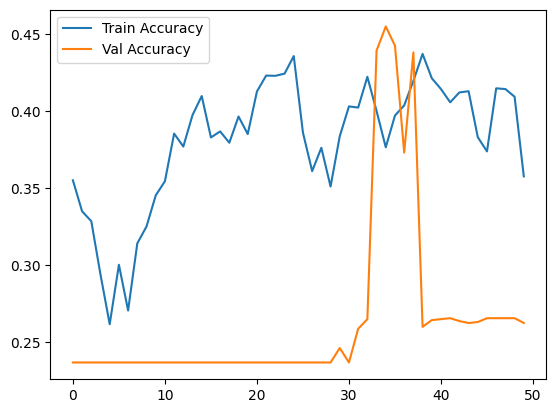

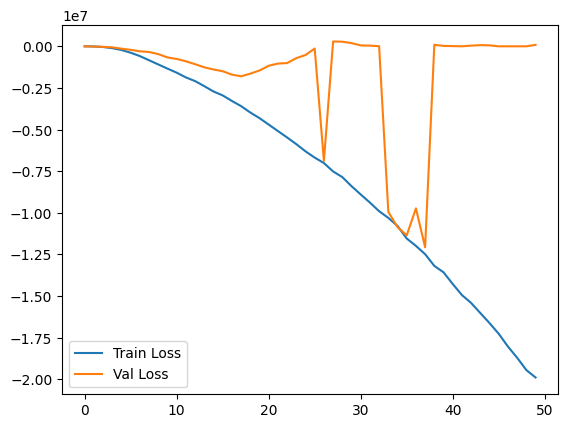

In [34]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

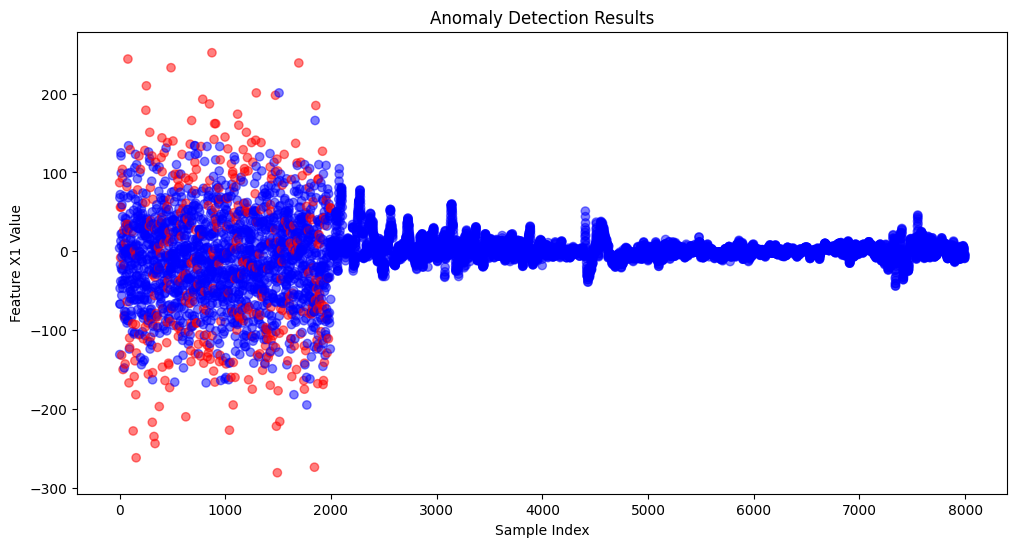

Detected 400 potential anomalies out of 8000 samples


In [29]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('BEED_Data.csv')

# Prepare features
X = data.drop('y', axis=1).values

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest for anomaly detection
model = IsolationForest(contamination=0.05, random_state=42)  # assuming 5% anomalies
model.fit(X_scaled)

# Predict anomalies (1 = normal, -1 = anomaly)
predictions = model.predict(X_scaled)

# Add predictions to dataframe
data['anomaly'] = predictions

# Visualize some features with anomalies marked
plt.figure(figsize=(12, 6))
plt.scatter(range(len(X)), X[:, 0], c=['red' if p == -1 else 'blue' for p in predictions], alpha=0.5)
plt.title("Anomaly Detection Results")
plt.xlabel("Sample Index")
plt.ylabel("Feature X1 Value")
plt.show()

# Count anomalies
n_anomalies = sum(predictions == -1)
print(f"Detected {n_anomalies} potential anomalies out of {len(X)} samples")

In [31]:
# Find most common complete pattern (all 16 features)
pattern_counts = data.drop('y', axis=1).value_counts()
most_common_pattern = pattern_counts.idxmax()
frequency = pattern_counts.max()

print(f"\nMost common complete pattern occurs {frequency} times:")
print(most_common_pattern)


Most common complete pattern occurs 1 times:
(np.int64(162), np.int64(133), np.int64(91), np.int64(32), np.int64(-31), np.int64(-85), np.int64(-120), np.int64(-142), np.int64(-148), np.int64(-136), np.int64(-93), np.int64(-21), np.int64(44), np.int64(100), np.int64(123), np.int64(129))


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data.drop('y', axis=1))

# Cluster the data
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Find modal pattern for each cluster
data['cluster'] = clusters
cluster_modes = data.groupby('cluster').agg(lambda x: stats.mode(x)[0][0])

print("\nModal patterns by cluster:")
print(cluster_modes.drop('y', axis=1))

In [ ]:
#fuzzy
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import skfuzzy as fuzz

# Load the data
data = pd.read_csv('/content/BEED_Data.csv')
X = data.drop('y', axis=1).values
y = data['y'].values

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Fuzzy preprocessing function
def fuzzy_preprocessing(X, n_clusters=3):
    """Apply fuzzy c-means clustering to each feature"""
    fuzzy_X = np.zeros((X.shape[0], X.shape[1] * n_clusters))

    for i in range(X.shape[1]):
        # Transpose to get correct shape for skfuzzy
        cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            X[:, i:i+1].T, n_clusters, 2, error=0.005, maxiter=1000)

        # For each sample, get membership values for all clusters
        for j in range(n_clusters):
            fuzzy_X[:, i*n_clusters + j] = u[j]

    return fuzzy_X

# Apply fuzzy preprocessing
n_clusters = 3
X_train_fuzzy = fuzzy_preprocessing(X_train, n_clusters)
X_test_fuzzy = fuzzy_preprocessing(X_test, n_clusters)

# Create and train Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_fuzzy, y_train)

# Predict and evaluate
y_pred = rf_classifier.predict(X_test_fuzzy)
accuracy = accuracy_score(y_test, y_pred)
print(f"Fuzzy-RandomForest Accuracy: {accuracy*100:.2f}%")

Fuzzy-RandomForest Accuracy: 26.56%


In [ ]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.1 MB/s eta 0:00:00


In [ ]:
import streamlit as st

st.slider("Input 1", 0, 10, 5)
if st.button("Run Fuzzy Logic"):
    output = your_fuzzy_system(input1, input2)
    st.write(f"Output: {output}")

2025-07-26 09:33:04.570 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 09:33:04.574 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 09:33:04.576 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 09:33:04.579 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-26 09:33:04.831 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-26 09:33:04.833 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when 

In [ ]:
!pip install streamlit pyngrok --quiet


In [ ]:
!pip install pyngrok
!ngrok authtoken YOUR_NGROK_AUTHTOKEN  # Get from https://dashboard.ngrok.com/auth

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
!ngrok authtoken YOUR_NEW_V2_AUTHTOKEN  # Replace with the new token

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [ ]:
# Install dependencies
# Write your Streamlit app
%%app.py
import streamlit as st

st.title("Fuzzy Logic System Demo")
input1 = st.slider("Input 1", 0.0, 10.0, 5.0)
input2 = st.slider("Input 2", 0.0, 10.0, 5.0)
output = (input1 + input2) / 2  # Replace with your fuzzy logic
st.success(f"Output: {output:.2f}")

# Run Streamlit with Ngrok
from pyngrok import ngrok
import subprocess
import threading

# Set ngrok authtoken (replace with your v2 token)
!ngrok authtoken YOUR_NEW_V2_AUTHTOKEN

# Start Streamlit in background
threading.Thread(
    target=lambda: subprocess.run(["streamlit", "run", "--server.port", "8501", "app.py"])
).start()

# Connect ngrok to Streamlit
public_url = ngrok.connect(addr="8501", bind_tls=True)
print("✨ Streamlit app live at:", public_url.public_url)

UsageError: Cell magic `%%app.py` not found.


In [ ]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

# Load the data
data = pd.read_csv('/content/BEED_Data.csv')
X = data.drop('y', axis=1).values
y = data['y'].values

# Normalize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create fuzzy variables for each feature
features = {}
for i in range(16):  # 16 features (x1-x16)
    features[f'x{i+1}'] = ctrl.Antecedent(np.linspace(0, 1, 100), f'x{i+1}')

# Output variable
output = ctrl.Consequent(np.linspace(0, 1, 100), 'output')

# Define membership functions (triangular for simplicity)
for feat in features.values():
    feat['low'] = fuzz.trimf(feat.universe, [0, 0, 0.5])
    feat['medium'] = fuzz.trimf(feat.universe, [0, 0.5, 1])
    feat['high'] = fuzz.trimf(feat.universe, [0.5, 1, 1])

output['class0'] = fuzz.trimf(output.universe, [0, 0, 0.5])
output['class1'] = fuzz.trimf(output.universe, [0.5, 1, 1])

# Create rules - now including all 16 features
rules = [
    # Rule 1: If x1 is low AND x2 is low AND x3 is low -> class0
    ctrl.Rule(features['x1']['low'] & features['x2']['low'] & features['x3']['low'], output['class0']),

    # Rule 2: If x1 is high OR x2 is high OR x3 is high -> class1
    ctrl.Rule(features['x1']['high'] | features['x2']['high'] | features['x3']['high'], output['class1']),

    # Rule 3: If x4 is medium AND x5 is high -> class1
    ctrl.Rule(features['x4']['medium'] & features['x5']['high'], output['class1']),

    # Rule 4: If x6 is low AND x7 is low AND x8 is medium -> class0
    ctrl.Rule(features['x6']['low'] & features['x7']['low'] & features['x8']['medium'], output['class0']),

    # Rule 5: Default rule if none of the above match
    ctrl.Rule(features['x1']['medium'] & features['x2']['medium'], output['class0'])
]

# Create control system
system = ctrl.ControlSystem(rules)
classifier = ctrl.ControlSystemSimulation(system)

# Enhanced predict function with better error handling
def fuzzy_predict(X):
    y_pred = []
    for sample in X:
        # Reset all inputs first
        for i in range(16):
            classifier.input[f'x{i+1}'] = 0  # Initialize all inputs

        # Set actual values
        for i in range(16):
            classifier.input[f'x{i+1}'] = sample[i]

        try:
            classifier.compute()
            y_pred.append(1 if classifier.output['output'] > 0.5 else 0)
        except Exception as e:
            print(f"Warning: {str(e)} - using default prediction")
            y_pred.append(0)  # Default prediction if computation fails
    return np.array(y_pred)

# Evaluate
y_pred = fuzzy_predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Fuzzy System Accuracy: {accuracy*100:.2f}%")

# Show some predictions vs actual
print("\nSample predictions:")
for i in range(min(10, len(X_test))):
    print(f"Sample {i+1}: Predicted {y_pred[i]}, Actual {y_test[i]}")

ValueError: Unexpected input: x9

In [ ]:
print(x9)  # Check if this variable exists

NameError: name 'x9' is not defined